In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
import shutil
import random
import os
import datetime
import tensorflow as tf

from sklearn.utils import shuffle
from PIL import Image
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Resizing, Rescaling, RandomFlip, RandomRotation, RandomBrightness, RandomContrast, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Input, Model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import pickle

In [66]:
path = "../FER2013"
emotions = os.listdir(f"{path}/train")

train_image = []
train_emotion = []

print("train data...")
for emotion in emotions:
    image_path = f"{path}/train/{emotion}"
    files = os.listdir(image_path)
    print(emotion)
    for file in files:
        img = cv2.imread(f"{image_path}/{file}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        train_image.append(img)
        train_emotion.append(emotion)


test_image = []
test_emotion = []

print("test data...")
for emotion in emotions:
    image_path = f"{path}/test/{emotion}"
    files = os.listdir(image_path)
    print(emotion)
    for file in files:
        img = cv2.imread(f"{image_path}/{file}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        test_image.append(img)
        test_emotion.append(emotion)


train_image = np.array(train_image)
train_emotion = np.array(train_emotion)
train_image, train_emotion = shuffle(train_image, train_emotion, random_state=0)

test_image = np.array(test_image)
test_emotion = np.array(test_emotion)
test_image, test_emotion = shuffle(test_image, test_emotion, random_state=0)

train data...
angry
disgust
fear
happy
neutral
sad
surprise
test data...
angry
disgust
fear
happy
neutral
sad
surprise


In [69]:
print(train_image[5].shape)
print(train_emotion.shape)
print(test_image.shape)
print(test_emotion.shape)
print(train_emotion[5])

(224, 224, 3)
(28709,)
(7178, 224, 224, 3)
(7178,)
angry


In [72]:
label_map = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
train_emotion_int = [label_map[label] for label in train_emotion]
train_emotion_int = np.array(train_emotion_int)

test_emotion_int = [label_map[label] for label in test_emotion]
test_emotion_int = np.array(test_emotion_int)

In [73]:
from keras.utils import to_categorical
train_emotion_onehot = to_categorical(train_emotion_int)
test_emotion_onehot = to_categorical(test_emotion_int)
print(train_emotion_onehot.shape)
print(test_emotion_onehot.shape)
print(train_emotion_onehot[4])

(28709, 7)
(7178, 7)
[0. 0. 0. 0. 0. 1. 0.]


In [75]:
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=12,
                                                  mode='max',
                                                  verbose=1,
                                                  restore_best_weights=True)



#preprocessing layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

    
base_model = MobileNetV3Large(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)  
base_model.trainable = False

#preprocessing layers + augmentations
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

x = base_model(x, training=False)

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)

x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)

x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)

outputs = Dense(7, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(train_image, train_emotion_onehot, batch_size=32,
                    epochs = 10, validation_split = 0.1,
                    callbacks = [early_stopping])


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_9   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_27 (Bat  (None, 960)              3840      
 chNormalization)                                                
                                                           

808/808 [==============================] - 593s 723ms/step - loss: 1.6539 - accuracy: 0.3575 - val_loss: 1.4141 - val_accuracy: 0.4622
Epoch 2/10
808/808 [==============================] - 567s 702ms/step - loss: 1.4900 - accuracy: 0.4231 - val_loss: 1.3775 - val_accuracy: 0.4842
Epoch 3/10
808/808 [==============================] - 567s 702ms/step - loss: 1.4403 - accuracy: 0.4407 - val_loss: 1.3493 - val_accuracy: 0.4855
Epoch 4/10
808/808 [==============================] - 570s 705ms/step - loss: 1.4089 - accuracy: 0.4574 - val_loss: 1.3339 - val_accuracy: 0.4869
Epoch 5/10
808/808 [==============================] - 571s 706ms/step - loss: 1.3892 - accuracy: 0.4669 - val_loss: 1.3316 - val_accuracy: 0.4981
Epoch 6/10
808/808 [==============================] - 568s 703ms/step - loss: 1.3754 - accuracy: 0.4704 - val_loss: 1.3358 - val_accuracy: 0.4897
Epoch 7/10
808/808 [==============================] - 570s 705ms/step - loss: 1.3576 - accuracy: 0.4806 - val_loss: 1.3179 - val_accura

In [76]:
model_dir = "models/model1_MobileNetV3Large"
model.save(model_dir)
pickle_out = open(f"history/model1_MobileNetV3Large",'wb')
pickle.dump(history, pickle_out)
pickle_out.close()

INFO:tensorflow:Assets written to: models/model1_MobileNetV3Large\assets


INFO:tensorflow:Assets written to: models/model1_MobileNetV3Large\assets


INFO:tensorflow:Assets written to: ram://457a571a-a832-4c42-a108-e902b86d6e8b/assets


INFO:tensorflow:Assets written to: ram://457a571a-a832-4c42-a108-e902b86d6e8b/assets


In [3]:
filename = "models/model1_MobileNetV3Large"
model = load_model(filename)
prediction = model.predict(x = test_image, batch_size = 10, verbose = 0)

NameError: name 'test_image' is not defined

In [85]:
predicted_labels = np.argmax(prediction, axis=1)
label_map = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
true_labels = np.argmax(test_emotion_onehot, axis=1)
num_of_wrong_predictions = 0

invalid_prediction = []
invalid_prediction_emotion = []
invalid_emotion = []

for i in range(len(test_emotion)):
    if label_map[true_labels[i]] != label_map[predicted_labels[i]]:
        invalid_prediction.append(test_image[i])
        invalid_prediction_emotion.append(prediction[i])
        invalid_emotion.append(test_emotion[i])


print(f"Accuracy:{len(invalid_emotion)/len(test_emotion)}")

invalid_prediction = np.array(invalid_prediction)
invalid_prediction_emotion = np.array(invalid_prediction_emotion)
invalid_emotion = np.array(invalid_emotion)

Accuracy:0.4917804402340485


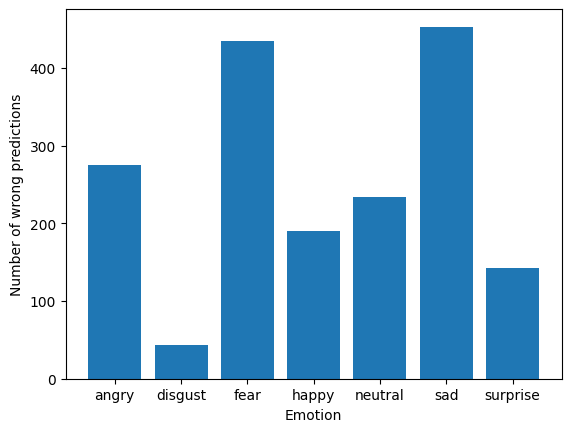

In [94]:
import matplotlib.pyplot as plt

wrong_predictions_per_emotion = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'neutral': 0, 'sad': 0, 'surprise': 0}

for i in range(len(invalid_emotion)):
    true_label = label_map[true_labels[i]]
    predicted_label = label_map[predicted_labels[i]]
    if true_label != predicted_label:
        wrong_predictions_per_emotion[true_label] += 1

plt.bar(wrong_predictions_per_emotion.keys(), wrong_predictions_per_emotion.values())
plt.xlabel('Emotion')
plt.ylabel('Number of wrong predictions')
plt.show()

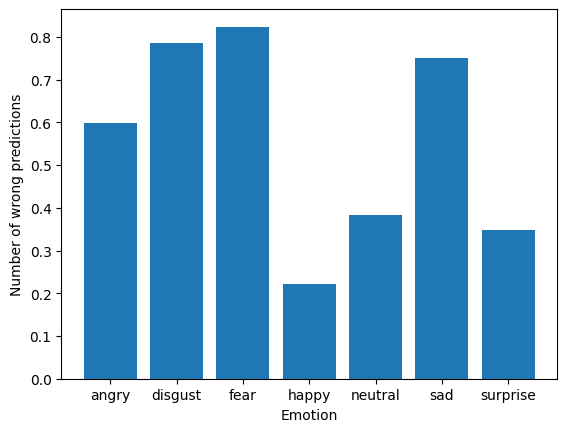

In [95]:
import matplotlib.pyplot as plt

wrong_predictions_per_emotion = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'neutral': 0, 'sad': 0, 'surprise': 0}
test_cases_per_emotion = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'neutral': 0, 'sad': 0, 'surprise': 0}
ratio_of_wrong_predictions = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'neutral': 0, 'sad': 0, 'surprise': 0}

for i in range(len(invalid_emotion)):
    true_label = label_map[true_labels[i]]
    predicted_label = label_map[predicted_labels[i]]
    test_cases_per_emotion[true_label] += 1
    if true_label != predicted_label:
        wrong_predictions_per_emotion[true_label] += 1

for emotion in emotions:
    ratio_of_wrong_predictions[emotion] = wrong_predictions_per_emotion[emotion] / test_cases_per_emotion[emotion]

plt.bar(ratio_of_wrong_predictions.keys(), ratio_of_wrong_predictions.values())
plt.xlabel('Emotion')
plt.ylabel('Number of wrong predictions')
plt.show()